In [1]:
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
import os
import random 
import cv2
import imutils
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
from keras.utils import np_utils
from keras.models import Sequential
from keras import optimizers
from sklearn.preprocessing import LabelBinarizer
from keras import backend as K
from keras.layers import Dense, Activation, Flatten, Dense,MaxPooling2D, Dropout
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

## 1. Pre-Processing 

In [2]:
dir = "input/handwritten-characters/Train/"
train_data = []
img_size = 32
for i in os.listdir(dir):
    count = 0
    sub_directory = os.path.join(dir,i)
    for j in os.listdir(sub_directory):
        count+=1
        if count > 1:
            break
        img = cv2.imread(os.path.join(sub_directory,j),0)
        img = cv2.resize(img,(img_size,img_size))
        train_data.append([img,i])

In [3]:
len(train_data)

35

In [4]:
val_dir = "input/handwritten-characters/Validation/"
val_data = []
img_size = 32
for i in os.listdir(val_dir):
    count = 0
    sub_directory = os.path.join(val_dir,i)
    for j in os.listdir(sub_directory):
        count+=1
        if count > 1:
            break
        img = cv2.imread(os.path.join(sub_directory,j),0)
        img = cv2.resize(img,(img_size,img_size))
        val_data.append([img,i])

In [5]:
len(val_data)

35

In [6]:
random.shuffle(train_data)
random.shuffle(val_data)

## 2. Segmentation

In [7]:
train_X = []
train_Y = []
for features,label in train_data:
    train_X.append(features)
    train_Y.append(label)

In [8]:
val_X = []
val_Y = []
for features,label in val_data:
    val_X.append(features)
    val_Y.append(label)

In [9]:
LB = LabelBinarizer()
train_Y = LB.fit_transform(train_Y)
val_Y = LB.fit_transform(val_Y)

## 3. Load Model

In [10]:
from tensorflow import keras
model = keras.models.load_model('hcr.h5')

## 4. Testing (Post-Processing) 
1. The sort contours function is used to get the correct order of individual characters for correct output extraction. In this case for extracting a single word, a left to right sorting of individual characters is needed.
2. The get letters function fetches the list of letters and get word function gets the individual word. 

In [11]:
def sort_contours(cnts, method="left-to-right"):
    reverse = False
    i = 0
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
    key=lambda b:b[1][i], reverse=reverse))
    
    return (cnts, boundingBoxes)

In [12]:
def get_letters(img):
    letters = []
    total_bbox_cordi = []
    image = cv2.imread(img)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret,thresh1 = cv2.threshold(gray ,127,255,cv2.THRESH_BINARY_INV)
    dilated = cv2.dilate(thresh1, None, iterations=2)

    cnts = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sort_contours(cnts, method="left-to-right")[0]
    
    for c in cnts:
        if cv2.contourArea(c) > 10:
            (x, y, w, h) = cv2.boundingRect(c)
            print([x,y,w,h])
            single_bbox_cordi = [x,y,w,h]
            total_bbox_cordi.append(single_bbox_cordi)
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        roi = gray[y:y + h, x:x + w]
        thresh = cv2.threshold(roi, 0, 255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        thresh = cv2.resize(thresh, (32, 32), interpolation = cv2.INTER_CUBIC)
        thresh = thresh.astype("float32") / 255.0
        thresh = np.expand_dims(thresh, axis=-1)
        thresh = thresh.reshape(1,32,32,1)
        ypred = model.predict(thresh)
        ypred = LB.inverse_transform(ypred)
        [x] = ypred
        letters.append(x)
    return letters, image, total_bbox_cordi



In [13]:
def get_word(letter):
    word = "".join(letter)
    return word

[67, 54, 60, 123]
1/1 [==============================] - 2s 2s/step
[147, 56, 69, 106]
1/1 [==============================] - 0s 108ms/step
[239, 54, 72, 91]
1/1 [==============================] - 0s 23ms/step
[320, 51, 69, 123]
1/1 [==============================] - 0s 23ms/step
[395, 63, 78, 106]
1/1 [==============================] - 0s 26ms/step
[475, 62, 60, 107]
1/1 [==============================] - 0s 28ms/step
[541, 59, 50, 105]
1/1 [==============================] - 0s 24ms/step
[607, 67, 43, 86]
1/1 [==============================] - 0s 24ms/step
[668, 52, 59, 103]
1/1 [==============================] - 0s 27ms/step
[752, 60, 73, 99]
1/1 [==============================] - 0s 28ms/step
[[67, 54, 60, 123], [147, 56, 69, 106], [239, 54, 72, 91], [320, 51, 69, 123], [395, 63, 78, 106], [475, 62, 60, 107], [541, 59, 50, 105], [607, 67, 43, 86], [668, 52, 59, 103], [752, 60, 73, 99]]
KECERDASAN


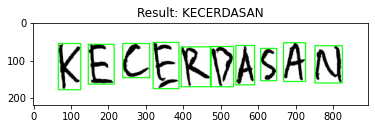

In [14]:
letter,image, total_bbox_cordi = get_letters("input/handwritten-characters/Test/test_1.jpg")
word = get_word(letter)
print(total_bbox_cordi)
plt.imshow(image)
plt.title('Result: ' + word)
print(word)

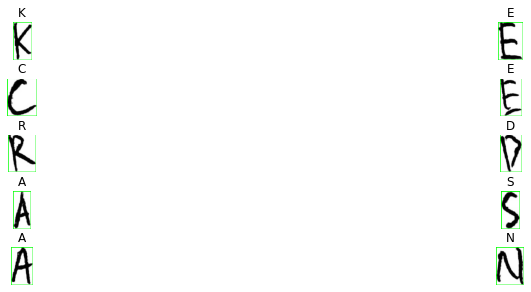

In [15]:
plt.figure(figsize=(15, 10))
for i in range(0,len(total_bbox_cordi)):
    ax = plt.subplot(10, 2, i+1)
    t =total_bbox_cordi[i]
    x_min = t[0]
    y_min = t[1]
    w_min = t[2]
    h_min= t[3]
    cropped_image = image[y_min:y_min+h_min, x_min:x_min+w_min]
    plt.title(letter[i], fontsize=12)
    plt.imshow(cropped_image)
    plt.axis('off')
plt.subplots_adjust(wspace=0.4, hspace=0.5)